This notebook is to test Contact rate analysis in our model

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Paths to simulation results
base_path = "../simulation_results_MalwareInfection"
models = ["D2D_RWP", "D2D_GAM"]

We have 10 runs for each model with different seed

In [3]:
# Number of runs (same as before)
num_runs = 10  # Total runs per model

In [4]:
# Load infection data as before
def load_infections(model):
    data = []
    for run in range(1, num_runs + 1):
        file_path = f"{base_path}/{model}/run_{run}_reports/infection_log.json"
        if os.path.exists(file_path):
            with open(file_path, "r") as f:
                entries = json.load(f)
                for entry in entries:
                    entry["run"] = run
                    entry["model"] = model
                data.extend(entries)
    return pd.DataFrame(data)

df_D2D_RWP = load_infections("D2D_RWP")
df_D2D_GAM = load_infections("D2D_GAM")
df_infections = pd.concat([df_D2D_RWP, df_D2D_GAM], ignore_index=True)

# Determine median runs
final_infection_times = df_infections.groupby(["model", "run"])["malware_active_time"].max().reset_index()

median_runs = final_infection_times.groupby("model").apply(
    lambda group: group.loc[(group["malware_active_time"] - group["malware_active_time"].median()).abs().idxmin()]
).reset_index(drop=True)

print(median_runs)


     model  run  malware_active_time
0  D2D_GAM    7               2799.0
1  D2D_RWP    3               1819.0


/tmp/ipykernel_1248127/4054429040.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_runs = final_infection_times.groupby("model").apply(


Load contact logs

In [5]:
# Function to load contact logs
def load_contact_logs(model):
    contact_data = []

    for run in range(1, num_runs + 1):
        file_path = f"{base_path}/{model}/run_{run}_reports/contact_log.json"
        
        if os.path.exists(file_path):
            with open(file_path, "r") as f:
                data = json.load(f)
                for entry in data:
                    entry["run"] = run
                    entry["model"] = model
                contact_data.extend(data)
        else:
            print(f"Warning: {file_path} not found!")

    return pd.DataFrame(contact_data)

# Load for both models
df_contacts_rwp = load_contact_logs("D2D_RWP")
df_contacts_gam = load_contact_logs("D2D_GAM")

# Combine
df_contacts = pd.concat([df_contacts_rwp, df_contacts_gam], ignore_index=True)

# Preview
df_contacts.head()

,to_node_infected_at_connection,connection_time,distance_between_nodes,connected_to,connection_key,malware_tranmissed,from_node_position_at_conn_start,to_node_position_at_conn_start,from_node_infected_at_connection,disconnection_time,node_id,run,model
0,False,0.5,151.170791,84,46-84,False,"(248.77,833.52)","(312.68,970.51)",False,7.5,46,1,D2D_RWP
1,False,0.5,151.989286,67,67-75,False,"(1206.31,299.70)","(1120.19,174.46)",False,17.5,75,1,D2D_RWP
2,False,0.5,150.104020,31,31-84,False,"(363.50,978.04)","(215.17,954.99)",False,19.0,84,1,D2D_RWP
3,False,0.5,152.328401,58,58-67,False,"(1114.62,164.98)","(1217.29,277.51)",False,20.0,67,1,D2D_RWP
4,False,0.5,151.958222,13,13-84,False,"(370.12,979.02)","(221.11,949.24)",False,20.5,84,1,D2D_RWP


Filter Contact Data for Median Runs

In [6]:
# Extract median run contact data
median_rwp_run_id = median_runs.loc[median_runs["model"] == "D2D_RWP", "run"].values[0]
median_gam_run_id = median_runs.loc[median_runs["model"] == "D2D_GAM", "run"].values[0]

df_contacts_rwp_median = df_contacts[(df_contacts["model"] == "D2D_RWP") & (df_contacts["run"] == median_rwp_run_id)]
df_contacts_gam_median = df_contacts[(df_contacts["model"] == "D2D_GAM") & (df_contacts["run"] == median_gam_run_id)]

In [7]:
# Select only the desired columns
contact_cols = ["node_id", "connected_to", "connection_time", "disconnection_time"]

# Extract contact table for RWP median run
median_rwp_run_id = median_runs.loc[median_runs["model"] == "D2D_RWP", "run"].values[0]
df_contacts_rwp_table = df_contacts[
    (df_contacts["model"] == "D2D_RWP") &
    (df_contacts["run"] == median_rwp_run_id)
][contact_cols].copy()

# Extract contact table for GAM median run
median_gam_run_id = median_runs.loc[median_runs["model"] == "D2D_GAM", "run"].values[0]
df_contacts_gam_table = df_contacts[
    (df_contacts["model"] == "D2D_GAM") &
    (df_contacts["run"] == median_gam_run_id)
][contact_cols].copy()

# Count number of rows in each contact table
num_rwp_contacts = df_contacts_rwp_table.shape[0]
num_gam_contacts = df_contacts_gam_table.shape[0]

print(f"📊 Total contact events in D2D_RWP median run: {num_rwp_contacts}")
print(f"📊 Total contact events in D2D_GAM median run: {num_gam_contacts}")

# Display the RWP contact table
print("📄 D2D_RWP - Contact Table (Median Run):")
display(df_contacts_rwp_table.head())  # Show first few rows

# Display the GAM contact table
print("📄 D2D_GAM - Contact Table (Median Run):")
display(df_contacts_gam_table.head())


📊 Total contact events in D2D_RWP median run: 5427
📊 Total contact events in D2D_GAM median run: 1715
📄 D2D_RWP - Contact Table (Median Run):


,node_id,connected_to,connection_time,disconnection_time
11147,60,65,0.5,14.5
11148,38,41,0.5,20.5
11149,60,45,0.5,21.5
11150,97,67,0.5,22.5
11151,50,60,0.5,24.5


📄 D2D_GAM - Contact Table (Median Run):


,node_id,connected_to,connection_time,disconnection_time
66974,77,42,0.5,8.0
66975,73,14,0.5,27.0
66976,18,24,0.5,31.5
66977,6,87,0.5,32.0
66978,39,4,0.5,35.0


Check for duplicates in dataset (node x connected y and node y connected to x at the same connect and disconnect tim)

In [8]:
def add_normalized_connection_key(df):
    # Create a consistent key by sorting the pair (node_id, connected_to)
    df["conn_pair"] = df.apply(lambda row: tuple(sorted([row["node_id"], row["connected_to"]])), axis=1)
    return df

# Apply to both median tables
df_contacts_rwp_table = add_normalized_connection_key(df_contacts_rwp_table)
df_contacts_gam_table = add_normalized_connection_key(df_contacts_gam_table)

# Check for duplicates in RWP
duplicates_rwp = df_contacts_rwp_table.groupby(["conn_pair", "connection_time", "disconnection_time"]).size()
duplicates_rwp = duplicates_rwp[duplicates_rwp > 1]

# Check for duplicates in GAM
duplicates_gam = df_contacts_gam_table.groupby(["conn_pair", "connection_time", "disconnection_time"]).size()
duplicates_gam = duplicates_gam[duplicates_gam > 1]

# Print results
print(f"🔍 Duplicate bidirectional entries in D2D_RWP: {len(duplicates_rwp)}")
print(f"🔍 Duplicate bidirectional entries in D2D_GAM: {len(duplicates_gam)}")


🔍 Duplicate bidirectional entries in D2D_RWP: 0
🔍 Duplicate bidirectional entries in D2D_GAM: 0


Pick 5 random time snapshots between 0.5 and 1900 seconds

In [9]:
snapshot_times = sorted(np.random.uniform(0.5, 1900, 5))
print("📸 Snapshot Times:", [round(t, 2) for t in snapshot_times])

📸 Snapshot Times: [np.float64(263.59), np.float64(335.87), np.float64(672.65), np.float64(779.08), np.float64(1821.33)]


Analyze each snapshot for RWP median run

In [10]:
for snapshot in snapshot_times:
    print(f"\n=== Snapshot at {round(snapshot, 2)} sec ===")

    # Filter connections that are active at this snapshot
    active_connections = df_contacts_rwp_table[
        (df_contacts_rwp_table["connection_time"] <= snapshot) &
        (df_contacts_rwp_table["disconnection_time"] >= snapshot)
    ]

    if active_connections.empty:
        print("No active connections at this snapshot.")
        continue

    # Step 3: Count how many connections each node is involved in
    node_counts = pd.concat([
        active_connections[["node_id"]],
        active_connections[["connected_to"]].rename(columns={"connected_to": "node_id"})
    ]).value_counts().sort_index()

    # Print results
    print(f"Total active connections: {len(active_connections)}")
    print("Number of connections per node:")
    display(node_counts.to_frame(name="connections"))


=== Snapshot at 263.59 sec ===
Total active connections: 114
Number of connections per node:


,connections
node_id,
0,2
1,3
2,2
3,2
4,3
...,...
94,1
95,5
96,4



=== Snapshot at 335.87 sec ===
Total active connections: 118
Number of connections per node:


,connections
node_id,
1,2
2,1
3,2
4,1
5,4
...,...
93,3
95,2
96,2



=== Snapshot at 672.65 sec ===
Total active connections: 111
Number of connections per node:


,connections
node_id,
1,2
2,1
3,1
4,4
5,2
...,...
95,1
96,2
97,3



=== Snapshot at 779.08 sec ===
Total active connections: 119
Number of connections per node:


,connections
node_id,
2,2
3,1
5,2
6,3
7,1
...,...
95,1
96,2
97,3



=== Snapshot at 1821.33 sec ===
Total active connections: 122
Number of connections per node:


,connections
node_id,
0,4
1,6
2,1
3,1
5,2
...,...
95,3
96,1
97,1


Analyze each snapshot for GAM median run

In [11]:
for snapshot in snapshot_times:
    print(f"\n=== Snapshot at {round(snapshot, 2)} sec ===")

    # Filter connections that are active at this snapshot
    active_connections = df_contacts_gam_table[
        (df_contacts_gam_table["connection_time"] <= snapshot) &
        (df_contacts_gam_table["disconnection_time"] >= snapshot)
    ]

    if active_connections.empty:
        print("No active connections at this snapshot.")
        continue

    # Step 3: Count how many connections each node is involved in
    node_counts = pd.concat([
        active_connections[["node_id"]],
        active_connections[["connected_to"]].rename(columns={"connected_to": "node_id"})
    ]).value_counts().sort_index()

    # Print results
    print(f"Total active connections: {len(active_connections)}")
    print("Number of connections per node:")
    display(node_counts.to_frame(name="connections"))


=== Snapshot at 263.59 sec ===
Total active connections: 78
Number of connections per node:


,connections
node_id,
1,1
2,4
4,2
5,2
6,1
...,...
94,2
95,1
96,2



=== Snapshot at 335.87 sec ===
Total active connections: 87
Number of connections per node:


,connections
node_id,
1,3
2,2
3,1
4,1
5,4
...,...
93,4
95,2
96,1



=== Snapshot at 672.65 sec ===
Total active connections: 180
Number of connections per node:


,connections
node_id,
1,1
2,2
3,1
4,7
5,8
...,...
95,1
96,5
97,6



=== Snapshot at 779.08 sec ===
Total active connections: 225
Number of connections per node:


,connections
node_id,
2,2
3,1
4,9
5,8
6,10
...,...
95,2
96,5
97,6



=== Snapshot at 1821.33 sec ===
Total active connections: 466
Number of connections per node:


,connections
node_id,
1,4
3,4
4,9
5,12
6,16
...,...
95,10
96,8
97,8


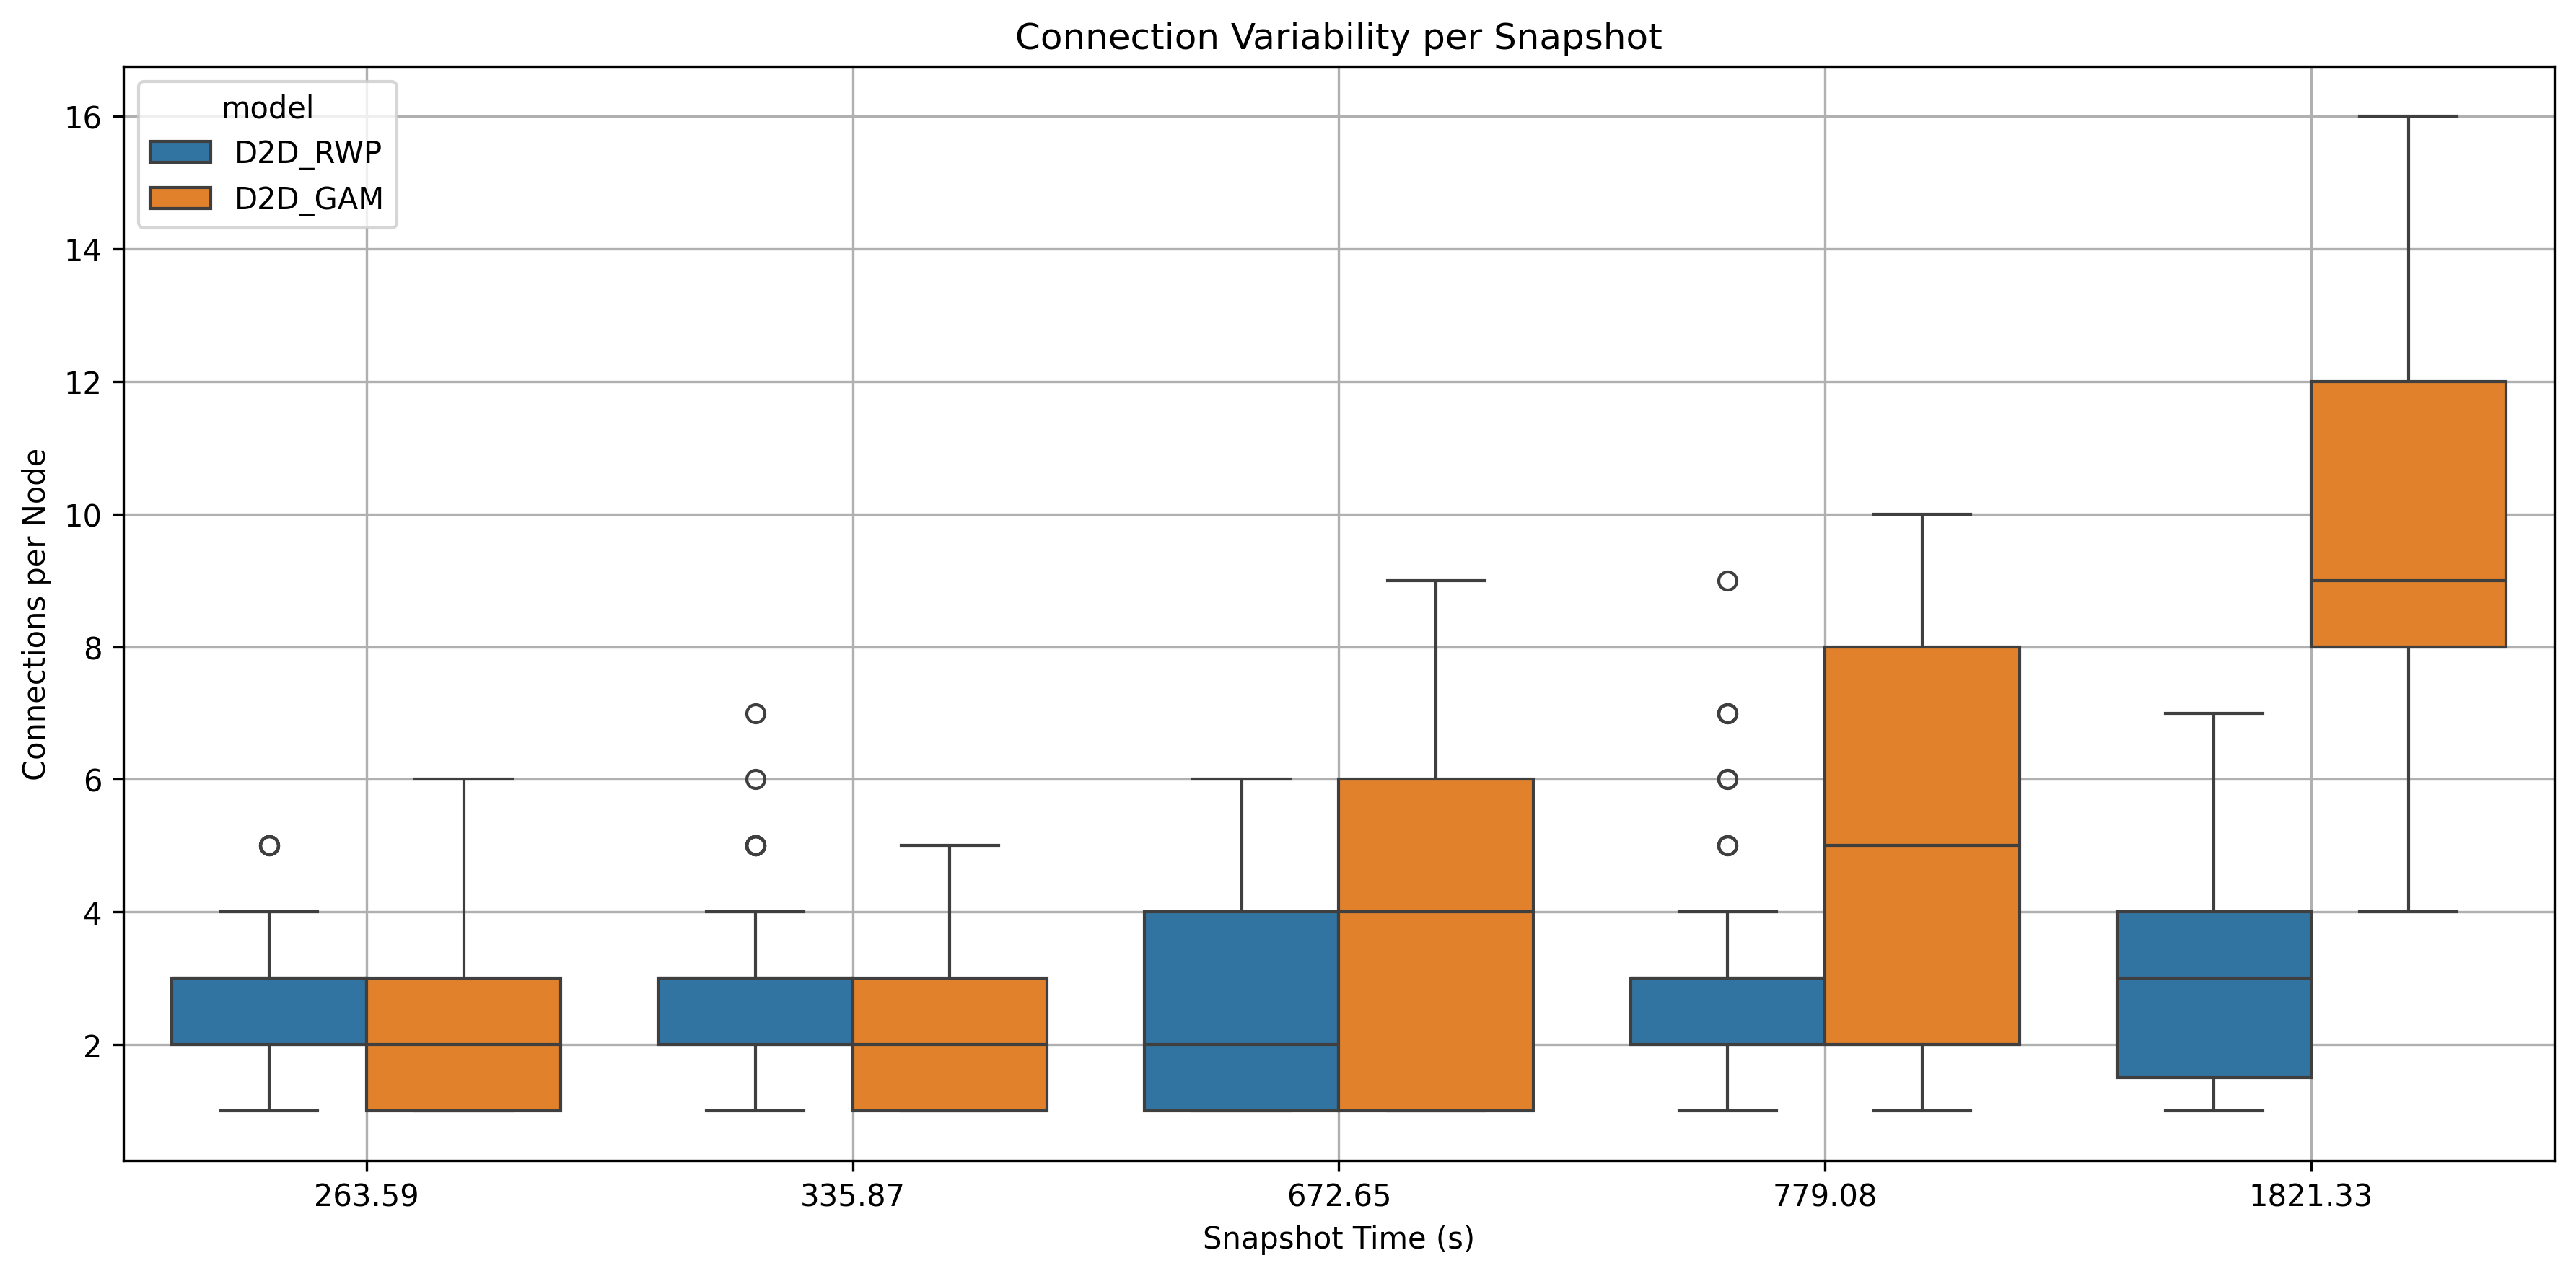

Median Connections per Node (across 5 snapshots):
  D2D_GAM: 4.0
  D2D_RWP: 3.0


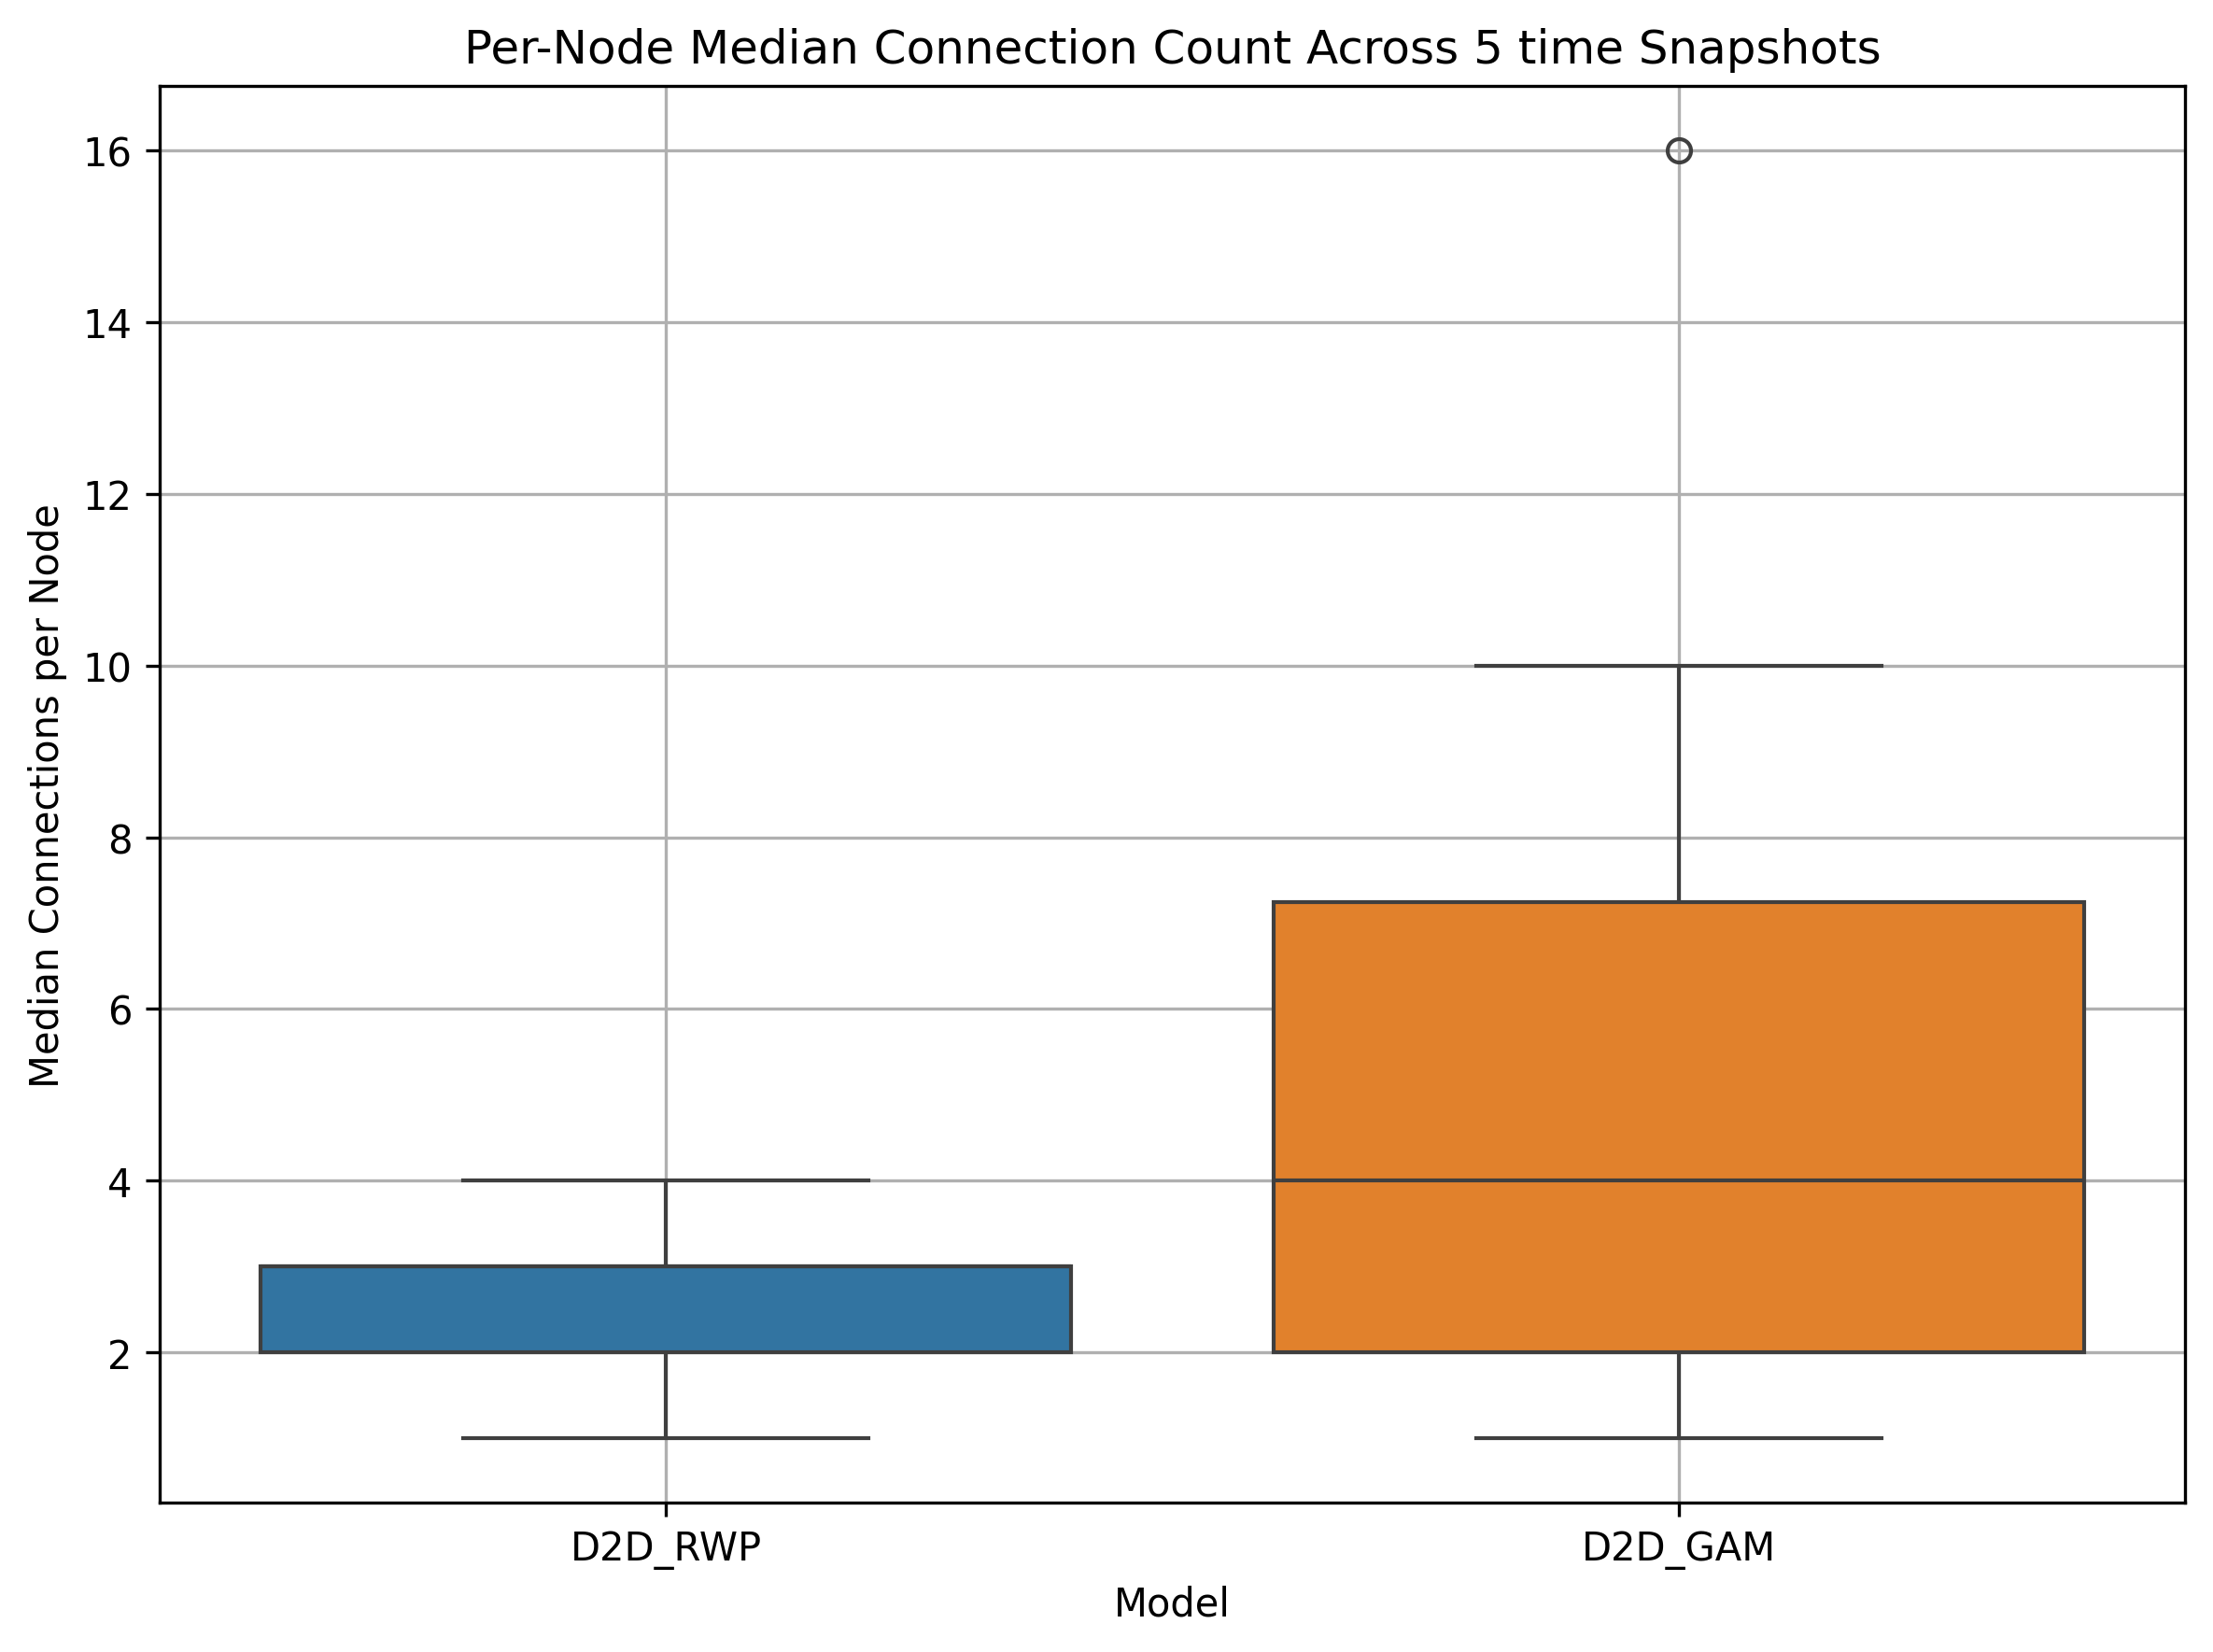

In [12]:
# Combine data for boxplot across snapshots and models
def prepare_snapshot_boxplot_df(contact_df, model_name):
    rows = []
    for snapshot in snapshot_times:
        # Get active connections at snapshot
        active = contact_df[
            (contact_df["connection_time"] <= snapshot) &
            (contact_df["disconnection_time"] >= snapshot)
        ]
        # Count connections per node
        counts = pd.concat([
            active[["node_id"]],
            active[["connected_to"]].rename(columns={"connected_to": "node_id"})
        ]).value_counts().sort_index()

        for node, count in counts.items():
            rows.append({
                "node_id": node,
                "connections": count,
                "time": round(snapshot, 2),
                "model": model_name
            })

    return pd.DataFrame(rows)

# Prepare data for both models
df_conn_rwp = prepare_snapshot_boxplot_df(df_contacts_rwp_table, "D2D_RWP")
df_conn_gam = prepare_snapshot_boxplot_df(df_contacts_gam_table, "D2D_GAM")

# Combine
df_conn_all = pd.concat([df_conn_rwp, df_conn_gam], ignore_index=True)

# 📊 Plot 1: Variability per snapshot time (by model)
plt.figure(figsize=(12, 6), dpi=300)
sns.boxplot(data=df_conn_all, x="time", y="connections", hue="model")
plt.xlabel("Snapshot Time (s)")
plt.ylabel("Connections per Node")
plt.title("Connection Variability per Snapshot")
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots/Connection_Variability_Per_Snapshot.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 📊 Plot 2: Overall Variability by Model
"""plt.figure(figsize=(8, 6), dpi=300)
sns.boxplot(data=df_conn_all, x="model", y="connections")
plt.xlabel("Model")
plt.ylabel("Connections per Node")
plt.title("Overall Variability in Connections")
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots/Connection_Variability_By_Model.pdf", format="pdf", bbox_inches="tight")
plt.show()"""

# Group by node and model, and take median across snapshots
df_median_conn = df_conn_all.groupby(["node_id", "model"])["connections"].median().reset_index()

# Print overall median connections for each model
median_by_model = df_median_conn.groupby("model")["connections"].median()
print("Median Connections per Node (across 5 snapshots):")
for model, value in median_by_model.items():
    print(f"  {model}: {value}")

# Plot median connection counts per node
plt.figure(figsize=(8, 6), dpi=300)
#sns.boxplot(data=df_median_conn, x="model", y="connections")
sns.boxplot(
    data=df_median_conn,
    x="model",
    y="connections",
    hue="model",
    dodge=False,
    order=["D2D_RWP", "D2D_GAM"],        # x-axis order
    hue_order=["D2D_RWP", "D2D_GAM"], 
)
plt.xlabel("Model")
plt.ylabel("Median Connections per Node")
plt.title("Per-Node Median Connection Count Across 5 time Snapshots")
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots/Median_Connections_Per_Node.pdf", format="pdf", bbox_inches="tight")
plt.show()